In [29]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd
from PIL import Image

def apply_adaptive_threshold(img):
    # 이미지를 그레이스케일로 변환
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    # 적응형 스레시홀딩 적용
    th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # PIL 이미지로 변환하여 반환
    return Image.fromarray(th_img)

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # 이미지 크기를 (50, 50)으로 변경
    transforms.Lambda(apply_adaptive_threshold),  # 적응형 스레시홀딩 적용 후 텐서로 변환
    transforms.ToTensor()  # 이미지를 텐서로 변환
])
data = ImageFolder(root="./data", transform=transform)
data2 = ImageFolder(root="./data_test", transform=transform)

In [30]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)
test_loader = DataLoader(data2, batch_size=8, shuffle=True)

In [31]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape) # shape : [개수, 채널 수, 높이, 너비]

torch.Size([10, 1, 50, 50]) torch.Size([10])


In [32]:
class Mob_Dog(nn.Module): # 클래스 생성
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) # 두번 컨볼루션 연산 해주기
        
        
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [34]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # dim=1을 주어 최종 값 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [35]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau # 스케줄러 생성 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{10}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model.state_dict(), 'model.pth')
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

Epoch [1/10], 횟수 [10/18], Loss: 0.7042: 100%|██████████| 18/18 [00:00<00:00, 34.73it/s]


0 Epoch 종료 후 train_score : 51.13636363636363
0 Epoch 종료 후 test_score : 45.67901234567901


Epoch [2/10], 횟수 [10/18], Loss: 0.6961: 100%|██████████| 18/18 [00:00<00:00, 47.01it/s]


1 Epoch 종료 후 train_score : 51.13636363636363
1 Epoch 종료 후 test_score : 45.67901234567901


Epoch [3/10], 횟수 [10/18], Loss: 0.6920: 100%|██████████| 18/18 [00:00<00:00, 44.28it/s]


2 Epoch 종료 후 train_score : 51.13636363636363
2 Epoch 종료 후 test_score : 45.67901234567901


Epoch [4/10], 횟수 [10/18], Loss: 0.6831: 100%|██████████| 18/18 [00:00<00:00, 46.97it/s]


3 Epoch 종료 후 train_score : 81.25
3 Epoch 종료 후 test_score : 67.90123456790124


Epoch [5/10], 횟수 [10/18], Loss: 0.6936: 100%|██████████| 18/18 [00:00<00:00, 46.29it/s]


4 Epoch 종료 후 train_score : 59.65909090909091
4 Epoch 종료 후 test_score : 46.913580246913575


Epoch [6/10], 횟수 [10/18], Loss: 0.6644: 100%|██████████| 18/18 [00:00<00:00, 46.56it/s]


5 Epoch 종료 후 train_score : 61.93181818181818
5 Epoch 종료 후 test_score : 50.617283950617285


Epoch [7/10], 횟수 [10/18], Loss: 0.5594: 100%|██████████| 18/18 [00:00<00:00, 46.29it/s]


6 Epoch 종료 후 train_score : 85.22727272727273
6 Epoch 종료 후 test_score : 65.4320987654321


Epoch [8/10], 횟수 [10/18], Loss: 0.4358: 100%|██████████| 18/18 [00:00<00:00, 45.53it/s]


7 Epoch 종료 후 train_score : 89.20454545454545
7 Epoch 종료 후 test_score : 70.37037037037037


Epoch [9/10], 횟수 [10/18], Loss: 0.3240: 100%|██████████| 18/18 [00:00<00:00, 45.74it/s]


8 Epoch 종료 후 train_score : 93.18181818181817
8 Epoch 종료 후 test_score : 61.72839506172839


Epoch [10/10], 횟수 [10/18], Loss: 0.1982: 100%|██████████| 18/18 [00:00<00:00, 46.90it/s]


9 Epoch 종료 후 train_score : 85.79545454545455
9 Epoch 종료 후 test_score : 54.32098765432099


Epoch [11/10], 횟수 [10/18], Loss: 0.2216: 100%|██████████| 18/18 [00:00<00:00, 45.47it/s]


10 Epoch 종료 후 train_score : 98.29545454545455
10 Epoch 종료 후 test_score : 58.0246913580247


Epoch [12/10], 횟수 [10/18], Loss: 0.0990: 100%|██████████| 18/18 [00:00<00:00, 47.30it/s]


11 Epoch 종료 후 train_score : 98.29545454545455
11 Epoch 종료 후 test_score : 56.79012345679012


Epoch [13/10], 횟수 [10/18], Loss: 0.0461: 100%|██████████| 18/18 [00:00<00:00, 46.56it/s]


12 Epoch 종료 후 train_score : 100.0
12 Epoch 종료 후 test_score : 67.90123456790124


Epoch [14/10], 횟수 [10/18], Loss: 0.0211: 100%|██████████| 18/18 [00:00<00:00, 46.58it/s]


13 Epoch 종료 후 train_score : 100.0
13 Epoch 종료 후 test_score : 65.4320987654321


Epoch [15/10], 횟수 [10/18], Loss: 0.0087: 100%|██████████| 18/18 [00:00<00:00, 46.73it/s]


14 Epoch 종료 후 train_score : 100.0
14 Epoch 종료 후 test_score : 62.96296296296296


Epoch [16/10], 횟수 [10/18], Loss: 0.0056: 100%|██████████| 18/18 [00:00<00:00, 44.77it/s]


15 Epoch 종료 후 train_score : 100.0
15 Epoch 종료 후 test_score : 64.19753086419753


Epoch [17/10], 횟수 [10/18], Loss: 0.0055: 100%|██████████| 18/18 [00:00<00:00, 46.79it/s]


16 Epoch 종료 후 train_score : 100.0
16 Epoch 종료 후 test_score : 62.96296296296296


Epoch [18/10], 횟수 [10/18], Loss: 0.0037: 100%|██████████| 18/18 [00:00<00:00, 43.21it/s]


17 Epoch 종료 후 train_score : 100.0
17 Epoch 종료 후 test_score : 65.4320987654321


Epoch [19/10], 횟수 [10/18], Loss: 0.0027: 100%|██████████| 18/18 [00:00<00:00, 47.20it/s]


18 Epoch 종료 후 train_score : 100.0
18 Epoch 종료 후 test_score : 62.96296296296296


Epoch [20/10], 횟수 [10/18], Loss: 0.0022: 100%|██████████| 18/18 [00:00<00:00, 48.22it/s]


19 Epoch 종료 후 train_score : 100.0
19 Epoch 종료 후 test_score : 65.4320987654321


Epoch [21/10], 횟수 [10/18], Loss: 0.0015: 100%|██████████| 18/18 [00:00<00:00, 44.87it/s]


20 Epoch 종료 후 train_score : 100.0
20 Epoch 종료 후 test_score : 62.96296296296296


Epoch [22/10], 횟수 [10/18], Loss: 0.0014: 100%|██████████| 18/18 [00:00<00:00, 45.70it/s]


21 Epoch 종료 후 train_score : 100.0
21 Epoch 종료 후 test_score : 65.4320987654321


Epoch [23/10], 횟수 [10/18], Loss: 0.0011: 100%|██████████| 18/18 [00:00<00:00, 45.88it/s]


22 Epoch 종료 후 train_score : 100.0
22 Epoch 종료 후 test_score : 62.96296296296296


Epoch [24/10], 횟수 [10/18], Loss: 0.0009: 100%|██████████| 18/18 [00:00<00:00, 46.78it/s]


23 Epoch 종료 후 train_score : 100.0
23 Epoch 종료 후 test_score : 65.4320987654321


Epoch [25/10], 횟수 [10/18], Loss: 0.0011: 100%|██████████| 18/18 [00:00<00:00, 39.20it/s]


24 Epoch 종료 후 train_score : 100.0
24 Epoch 종료 후 test_score : 62.96296296296296


Epoch [26/10], 횟수 [10/18], Loss: 0.0008: 100%|██████████| 18/18 [00:00<00:00, 49.51it/s]


25 Epoch 종료 후 train_score : 100.0
25 Epoch 종료 후 test_score : 61.72839506172839


Epoch [27/10], 횟수 [10/18], Loss: 0.0007: 100%|██████████| 18/18 [00:00<00:00, 47.04it/s]


26 Epoch 종료 후 train_score : 100.0
26 Epoch 종료 후 test_score : 66.66666666666666


Epoch [28/10], 횟수 [10/18], Loss: 0.0007: 100%|██████████| 18/18 [00:00<00:00, 48.82it/s]


27 Epoch 종료 후 train_score : 100.0
27 Epoch 종료 후 test_score : 61.72839506172839


Epoch [29/10], 횟수 [10/18], Loss: 0.0006: 100%|██████████| 18/18 [00:00<00:00, 45.95it/s]


28 Epoch 종료 후 train_score : 100.0
28 Epoch 종료 후 test_score : 66.66666666666666


Epoch [30/10], 횟수 [10/18], Loss: 0.0005: 100%|██████████| 18/18 [00:00<00:00, 46.89it/s]


29 Epoch 종료 후 train_score : 100.0
29 Epoch 종료 후 test_score : 61.72839506172839


Epoch [31/10], 횟수 [10/18], Loss: 0.0004: 100%|██████████| 18/18 [00:00<00:00, 45.47it/s]


30 Epoch 종료 후 train_score : 100.0
30 Epoch 종료 후 test_score : 61.72839506172839


Epoch [32/10], 횟수 [10/18], Loss: 0.0003: 100%|██████████| 18/18 [00:00<00:00, 44.08it/s]


31 Epoch 종료 후 train_score : 100.0
31 Epoch 종료 후 test_score : 61.72839506172839


Epoch [33/10], 횟수 [10/18], Loss: 0.0003: 100%|██████████| 18/18 [00:00<00:00, 40.67it/s]


32 Epoch 종료 후 train_score : 100.0
32 Epoch 종료 후 test_score : 65.4320987654321


Epoch [34/10], 횟수 [10/18], Loss: 0.0003: 100%|██████████| 18/18 [00:00<00:00, 43.83it/s]


33 Epoch 종료 후 train_score : 100.0
33 Epoch 종료 후 test_score : 61.72839506172839


Epoch [35/10], 횟수 [10/18], Loss: 0.0003: 100%|██████████| 18/18 [00:00<00:00, 44.64it/s]


34 Epoch 종료 후 train_score : 100.0
34 Epoch 종료 후 test_score : 64.19753086419753


Epoch [36/10], 횟수 [10/18], Loss: 0.0002: 100%|██████████| 18/18 [00:00<00:00, 44.14it/s]


35 Epoch 종료 후 train_score : 100.0
35 Epoch 종료 후 test_score : 62.96296296296296


Epoch [37/10], 횟수 [10/18], Loss: 0.0002: 100%|██████████| 18/18 [00:00<00:00, 43.87it/s]


36 Epoch 종료 후 train_score : 100.0
36 Epoch 종료 후 test_score : 64.19753086419753


Epoch [38/10], 횟수 [10/18], Loss: 0.0002: 100%|██████████| 18/18 [00:00<00:00, 43.28it/s]


37 Epoch 종료 후 train_score : 100.0
37 Epoch 종료 후 test_score : 61.72839506172839


Epoch [39/10], 횟수 [10/18], Loss: 0.0002: 100%|██████████| 18/18 [00:00<00:00, 43.36it/s]


38 Epoch 종료 후 train_score : 100.0
38 Epoch 종료 후 test_score : 61.72839506172839


Epoch [40/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 39.61it/s]


39 Epoch 종료 후 train_score : 100.0
39 Epoch 종료 후 test_score : 64.19753086419753


Epoch [41/10], 횟수 [10/18], Loss: 0.0002: 100%|██████████| 18/18 [00:00<00:00, 45.43it/s]


40 Epoch 종료 후 train_score : 100.0
40 Epoch 종료 후 test_score : 61.72839506172839


Epoch [42/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 43.71it/s]


41 Epoch 종료 후 train_score : 100.0
41 Epoch 종료 후 test_score : 61.72839506172839


Epoch [43/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.69it/s]


42 Epoch 종료 후 train_score : 100.0
42 Epoch 종료 후 test_score : 64.19753086419753


Epoch [44/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.71it/s]


43 Epoch 종료 후 train_score : 100.0
43 Epoch 종료 후 test_score : 64.19753086419753


Epoch [45/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 43.21it/s]


44 Epoch 종료 후 train_score : 100.0
44 Epoch 종료 후 test_score : 61.72839506172839


Epoch [46/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.59it/s]


45 Epoch 종료 후 train_score : 100.0
45 Epoch 종료 후 test_score : 61.72839506172839


Epoch [47/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 40.25it/s]


46 Epoch 종료 후 train_score : 100.0
46 Epoch 종료 후 test_score : 64.19753086419753


Epoch [48/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 43.24it/s]


47 Epoch 종료 후 train_score : 100.0
47 Epoch 종료 후 test_score : 64.19753086419753


Epoch [49/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 39.46it/s]


48 Epoch 종료 후 train_score : 100.0
48 Epoch 종료 후 test_score : 64.19753086419753


Epoch [50/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 41.78it/s]


49 Epoch 종료 후 train_score : 100.0
49 Epoch 종료 후 test_score : 64.19753086419753


Epoch [51/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 41.94it/s]


50 Epoch 종료 후 train_score : 100.0
50 Epoch 종료 후 test_score : 61.72839506172839


Epoch [52/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 41.76it/s]


51 Epoch 종료 후 train_score : 100.0
51 Epoch 종료 후 test_score : 64.19753086419753


Epoch [53/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.64it/s]


52 Epoch 종료 후 train_score : 100.0
52 Epoch 종료 후 test_score : 61.72839506172839


Epoch [54/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.40it/s]


53 Epoch 종료 후 train_score : 100.0
53 Epoch 종료 후 test_score : 62.96296296296296


Epoch [55/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 42.45it/s]


54 Epoch 종료 후 train_score : 100.0
54 Epoch 종료 후 test_score : 64.19753086419753


Epoch [56/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.07it/s]


55 Epoch 종료 후 train_score : 100.0
55 Epoch 종료 후 test_score : 62.96296296296296


Epoch [57/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.09it/s]


56 Epoch 종료 후 train_score : 100.0
56 Epoch 종료 후 test_score : 64.19753086419753


Epoch [58/10], 횟수 [10/18], Loss: 0.0001: 100%|██████████| 18/18 [00:00<00:00, 37.54it/s]


57 Epoch 종료 후 train_score : 100.0
57 Epoch 종료 후 test_score : 62.96296296296296


Epoch [59/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.48it/s]


58 Epoch 종료 후 train_score : 100.0
58 Epoch 종료 후 test_score : 64.19753086419753


Epoch [60/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.33it/s]


59 Epoch 종료 후 train_score : 100.0
59 Epoch 종료 후 test_score : 64.19753086419753


Epoch [61/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.01it/s]


60 Epoch 종료 후 train_score : 100.0
60 Epoch 종료 후 test_score : 62.96296296296296


Epoch [62/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 41.71it/s]


61 Epoch 종료 후 train_score : 100.0
61 Epoch 종료 후 test_score : 64.19753086419753


Epoch [63/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.43it/s]


62 Epoch 종료 후 train_score : 100.0
62 Epoch 종료 후 test_score : 62.96296296296296


Epoch [64/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 40.77it/s]


63 Epoch 종료 후 train_score : 100.0
63 Epoch 종료 후 test_score : 62.96296296296296


Epoch [65/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 40.97it/s]


64 Epoch 종료 후 train_score : 100.0
64 Epoch 종료 후 test_score : 62.96296296296296


Epoch [66/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.22it/s]


65 Epoch 종료 후 train_score : 100.0
65 Epoch 종료 후 test_score : 64.19753086419753


Epoch [67/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 38.83it/s]


66 Epoch 종료 후 train_score : 100.0
66 Epoch 종료 후 test_score : 61.72839506172839


Epoch [68/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.20it/s]


67 Epoch 종료 후 train_score : 100.0
67 Epoch 종료 후 test_score : 64.19753086419753


Epoch [69/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 43.01it/s]


68 Epoch 종료 후 train_score : 100.0
68 Epoch 종료 후 test_score : 64.19753086419753


Epoch [70/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 41.88it/s]


69 Epoch 종료 후 train_score : 100.0
69 Epoch 종료 후 test_score : 62.96296296296296


Epoch [71/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.13it/s]


70 Epoch 종료 후 train_score : 100.0
70 Epoch 종료 후 test_score : 64.19753086419753


Epoch [72/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.33it/s]


71 Epoch 종료 후 train_score : 100.0
71 Epoch 종료 후 test_score : 62.96296296296296


Epoch [73/10], 횟수 [10/18], Loss: 0.0000: 100%|██████████| 18/18 [00:00<00:00, 42.75it/s]


72 Epoch 종료 후 train_score : 100.0
72 Epoch 종료 후 test_score : 62.96296296296296
Early Stopping at : 72 Epoch


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

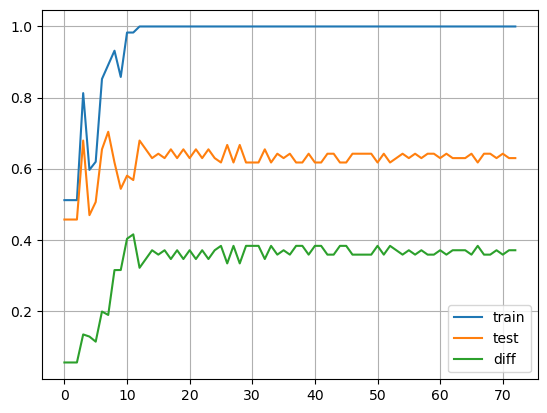

In [46]:
import matplotlib.pyplot as plt

#plt.plot(loss_list)
plt.plot(tas_list, label="train")
plt.plot(tes_list, label="test")
plt.plot(np.array(tas_list)-np.array(tes_list), label="diff")
plt.grid(True)
plt.legend()
plt.ylabel

In [47]:
# 과적합이 뜬다...이번에는 모델에 dropout과 batch normalization을 추가로 작업해보자! 

In [50]:
model = Mob_Dog()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# 이미지 예측
img = cv2.imread('./data/mop_dog/74.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50, 50))
img = img / 255.0
img = torch.Tensor(img)
img = img.unsqueeze(0)

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
predicted, output # 이런 젠장, 걸레라고 나온다 

(tensor([0]), tensor([[ 0.5850, -0.8256]]))